In [1112]:
import csv
import random
import os
from IPython.display import clear_output
from sklearn.preprocessing import RobustScaler, MinMaxScaler, normalize
from sklearn import preprocessing
import librosa
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

filename = './BMD-HS-Dataset/train.csv'

In [1113]:
with open(filename) as f:
    reader = csv.reader(f)
    chosen_row = random.choice(list(reader))

print(chosen_row[6])

N_104_sup_Mit


In [1114]:
filename = os.path.join('.', 'BMD-HS-Dataset', 'train', chosen_row[6] + '.wav')

In [1115]:
req_len = 20
data, rate = librosa.load(filename, sr=None, mono=True)
req_samples = req_len * rate
if(rate*len(data) > req_len):
  data = data[(len(data) - req_samples) // 2:req_samples + (len(data) - req_samples) // 2]
elif (rate*len(data) < req_len):
  data = np.pad(data, ((req_samples - len(data)) // 2))

data = normalize(data[:,np.newaxis], axis=0, norm='max').ravel()

print(data)
print(len(data)/rate, rate, len(data))

[ 0.          0.          0.         ...  0.00384521  0.00045776
 -0.00274658]
20.0 4000 80000


In [1116]:
t = np.arange (0, len(data)/rate, 1/rate)
print(t, len(t)/rate)

[0.000000e+00 2.500000e-04 5.000000e-04 ... 1.999925e+01 1.999950e+01
 1.999975e+01] 20.0


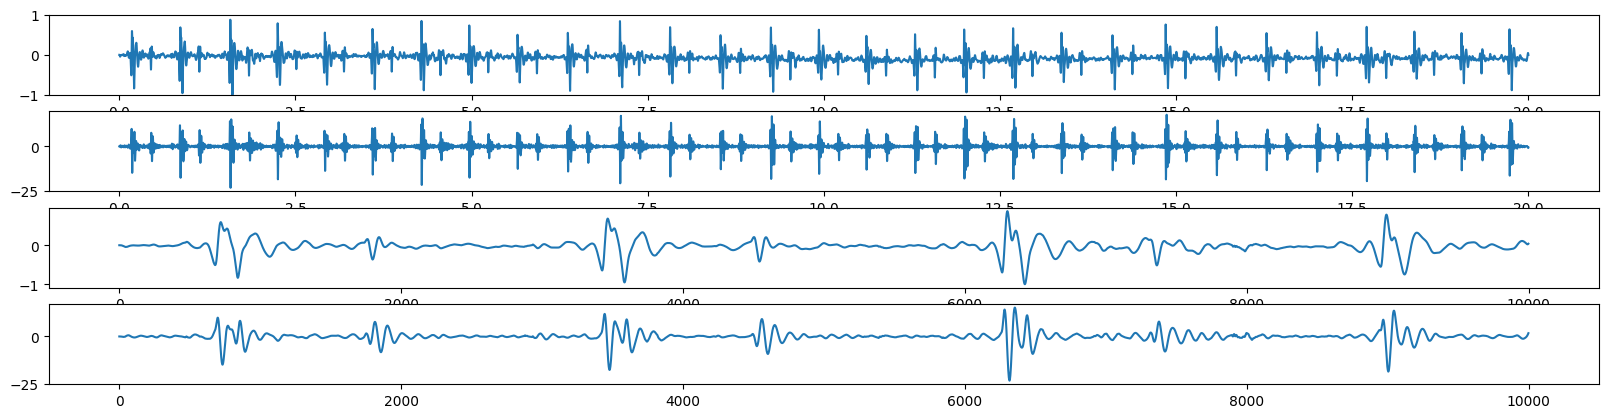

In [1117]:
# scaler = preprocessing.MinMaxScaler()
# scaler = preprocessing.MaxAbsScaler()
# scaler = preprocessing.StandardScaler()
scaler = preprocessing.RobustScaler()

fig, (ax0, ax1, ax2, ax3) = plt.subplots(nrows=4)

ax0.plot(t, data)
sos = signal.ellip(3, 1, 500, 9, 'hp', fs=1000, output='sos')
data_filtered = signal.sosfilt(sos, data)

data_filtered = scaler.fit_transform(data_filtered[:, np.newaxis])

ax1.plot(t, data_filtered)

ax2.plot(data[0:400 * 25])
ax3.plot(data_filtered[0:400 * 25])

fig.set_figwidth(20)
ax0.set_ybound(-1, 1)
plt.show()

In [ ]:
def get_cut_data(data : np.ndarray, pad : int = 0, window : int = 100, peak_h : float = 0.8, npeaks : int = 3, time : float = 10, out : str = 'time', rate : int = 1000):
  retdata = data #+ 1
  retdata = retdata[pad:]
  scaler = preprocessing.MinMaxScaler()
  peak_dots = [[0, 0]]

  energy_seq = []
  for i in range(len(retdata) // window):
    energy_sum = 0
    for element in retdata[i * window : (i + 1) * window]:
      energy_sum += element**2
    energy_seq.append(energy_sum)

  energies_mean = np.array(energy_seq).mean()
  energies_dev = np.std(energy_seq)
  z_scores = (energy_seq - energies_mean) / energies_dev
  energy_seq = scaler.fit_transform(z_scores[:, np.newaxis]).flatten()

  for i in range(len(energy_seq)): # cut untill face first high cardiac impulse
    if peak_h < energy_seq[i]: 
      peak_dots[0][1] = energy_seq[i]
      break
  retdata = retdata[i * window:]
  energy_seq = energy_seq[i :]
  
  if(out == 'npeaks'):
    pad_pos = 0
    for _ in range(npeaks):
      for i in range(pad_pos + 1, len(energy_seq)):
        if energy_seq[i] > peak_h: break
      pad_pos = i
      peak_dots.append([i, energy_seq[i]])
      print(i)
    retdata = retdata[:(i + 1) * window]
    energy_seq = energy_seq[: (i+1)]
  elif(out == 'time'):
    retdata = retdata[:int(rate * time) + 1]
    energy_seq = energy_seq[:int(rate * time / window) + 1]
  
  return retdata, energy_seq, np.array(peak_dots)

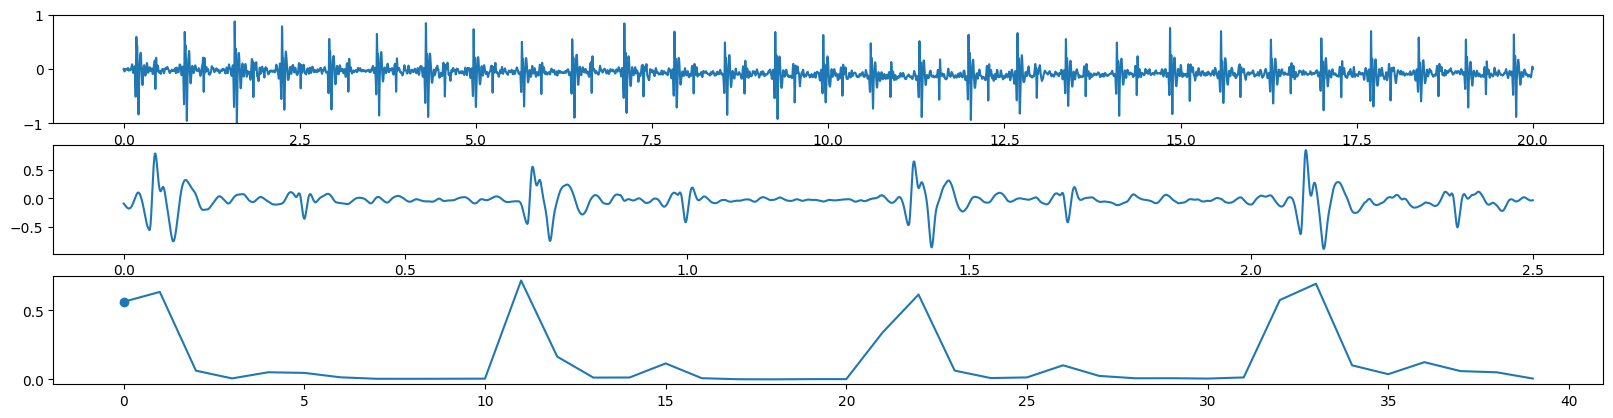

In [1121]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=False)

axs[0].plot(t, data)
data_cut, energy, dots = get_cut_data(data, window=256, peak_h=0.4, npeaks=5, pad=rate*2)
axs[1].plot(np.linspace(0, len(data_cut)/rate, len(data_cut)), data_cut)
axs[2].plot(energy)
axs[2].scatter(dots[:,0], dots[:,1])

fig.set_figwidth(20)
axs[0].set_ybound(-1, 1)
# ax1.set_xticks(range(0, len(data_cut), 400))
plt.show()

In [24]:
%matplotlib inline 
#pip install jupyter ipympl - for this

def live_plot(data, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.plot(data)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show();

# arr = []
# for i in range (100):
#   arr.append(i**2)
#   live_plot(arr)


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [26]:

class SinglePatientData:
  def __init__(self, names : list, flags : list):
    self.contents = {
              'sup_mit_file_name' : '', 
              'sup_tri_file_name' : '' , 
              'sup_pul_file_name' : '' , 
              'sup_aor_file_name' : '' ,
              'sit_mit_file_name' : '' , 
              'sit_tri_file_name' : '' , 
              'sit_pul_file_name' : '' , 
              'sit_aor_file_name' : '' ,}
  
    self.diagnosis_flags = {'AorticStenosis' : 0, 
                      'AorticRegurgitation' : 0,
                      'Mitral Regirgitation' : 0,
                      'Mitral Stenosis' : 0,
                      'Normal' : 0}
    i = 0
    for key in self.contents:
      try: #todo
        self.contents[key] = names[i];
      except:
        self.contents[key] = ''
      finally:
        i += 1
    i = 0
    for key in self.diagnosis_flags:
      try:
        self.diagnosis_flags[key] = int(flags[i]);
      except:
        self.diagnosis_flags[key] = 0
      finally:
        i += 1
  def getTensor(self, path): # returns 129x1249x5 torch tensor
    if (hasattr(self, 'specgrams')):
      return self.specgrams
    else:
      returned_tensor = []
      for name in list(self.contents.values()):
        req_len = 20
        data, rate = librosa.load(os.path.join(path, name + '.wav'), sr=None, mono=True)
        req_samples = req_len * rate
        if(len(data) > req_len * rate):
          data = data[(len(data) - req_samples) // 2:req_samples + (len(data) - req_samples) // 2]
        elif (len(data) < req_len * rate):
          data = np.pad(data, ((req_samples - len(data)) // 2))
        
        data = normalize(data[:,np.newaxis], axis=0, norm='max').ravel()

        returned_tensor.append(data)
      returned_tensor = np.array(returned_tensor, dtype=np.float32)

      self.specgrams = torch.from_numpy(returned_tensor)
      return self.specgrams
    

In [27]:
def createDataArray(csvFilename):
  with open(csvFilename) as file:
    retArray = []
    reader = csv.reader(file, delimiter=',')
    reader.__next__() 
    for row in reader:
      retArray.append(SinglePatientData(list(row[6 : ]), list(row[1: 6])))
    return retArray

In [28]:
print(torch.__version__)

2.5.1+cu124


In [29]:
class RnnModel(nn.Module):
    def __init__(self):
        super(RnnModel, self).__init__()
        lin_layers = []
        
        self.rnn1 = nn.RNN(input_size=8, hidden_size=16, num_layers=2)

        self.fc = nn.Linear(in_features=16, out_features=5)

    def forward(self, x):

        out, hn = self.rnn1(x)
        # out = self.fc(hn)
        out = self.fc(out[:, -1, :])
        return out

In [30]:
foldername = os.path.join('.', 'BMD-HS-Dataset')
trainFoldername = os.path.join(foldername, 'train')
trainCsvName = os.path.join(foldername, 'train.csv')

dataArray = createDataArray(trainCsvName)
dataIterator = iter(dataArray)

In [31]:
model = RnnModel()
Pxx = torch.reshape(next(dataIterator).getTensor(trainFoldername), (80000, 8))
Pxx = torch.unsqueeze(Pxx, dim=0)
print(Pxx.shape)
out = model(Pxx)
print(out.shape)


torch.Size([1, 80000, 8])
torch.Size([1, 5])


In [ ]:
learning_rate = 0.002
num_epochs = 200

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = RnnModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [33]:
def get_acc(logit, target):
    ''' Check if answer is right for training round '''
    round_logit = torch.round(logit)
    acc = 0
    for i in range(len(target)):
        ans = (1 if 0 <= int(round_logit[i].item()) else 0)
        acc += (1 if ans == int(target[i].item()) else 0)
    return acc / len(target)

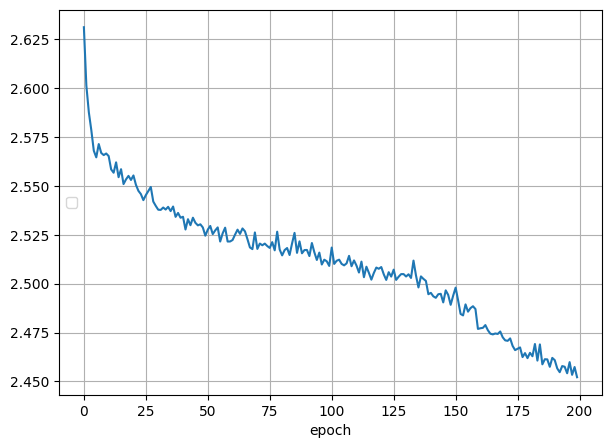

Epoch: 199 | Loss: 2.4521 | Train Accuracy: 0.48


In [34]:
train_acc = 0
epoch = 0
accuracies = []
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    random.shuffle(dataArray)
    dataIterator = iter(dataArray)
    ## training step
    for i, patient in enumerate(dataIterator):
        labels = torch.tensor(list(patient.diagnosis_flags.values()), dtype=torch.float32)
        labels = torch.unsqueeze(labels, dim=0)

        Pxx = patient.getTensor(trainFoldername);

        ## forward + backprop + loss
        Pxx = torch.reshape(patient.getTensor(trainFoldername), (80000, 8))
        Pxx = torch.unsqueeze(Pxx, dim=0)

        logits = model(Pxx)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_acc(logits[0], labels[0])
        # print('Loss curr: %.4f, loss mean: %.4f' %(loss.detach().item(), train_running_loss / (i + 1)))
        # print('target: %s, logits: %s, loss: %f' %(labels, logits, train_running_loss / (i + 1), train_acc / (i + 1)))
        print(labels, logits, get_acc(logits[0], labels[0]))


    model.eval()
    accuracies += [train_running_loss / i]
    live_plot(accuracies)
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))